(1932, 3)


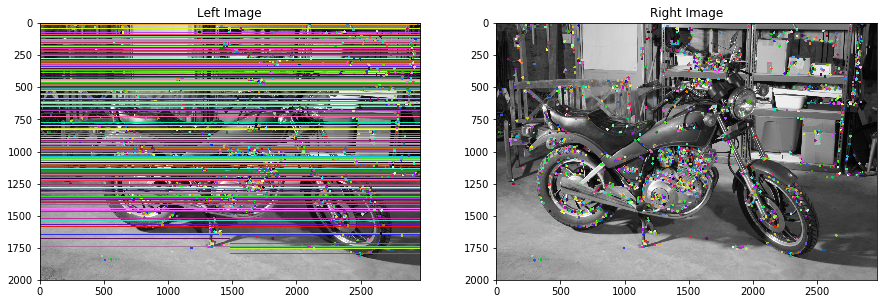

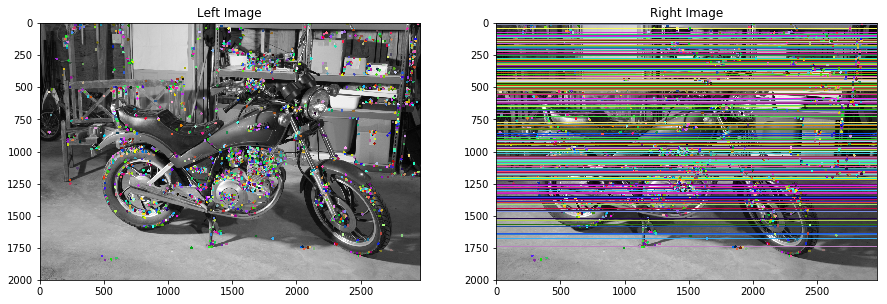

In [238]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 10, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 10, color, -1)
    return img1, img2


# load left and right images
imgL = cv2.imread("im0.png", 0)
imgR = cv2.imread("im1.png", 0)
row, col = imgL.shape

############################################################
#PART 1

#sift object
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)


# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)


# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

#PART 1 DONE
############################################################


############################################################
#PART 2

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
print(linesL.shape)
#draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), 
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), 
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), 
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"),
plt.show()

#PART 2 DONE
############################################################


Chosen keypoint on right image [2309  317]

sorted SSDs array
 [3.89000e+02 5.53000e+02 7.05000e+02 ... 4.95133e+05 4.98112e+05
 4.98120e+05]

Min SSD at x position = 2397

Min SSD = 389.0

right image patch
 [[141 145 131 130 127]
 [153 154 147 146 146]
 [154 157 156 158 158]
 [152 154 156 155 151]
 [143 146 147 146 144]]

left image patch
 [[168 144 134 144 134]
 [164 149 145 153 144]
 [165 159 159 159 155]
 [153 151 153 156 157]
 [142 141 142 145 150]]


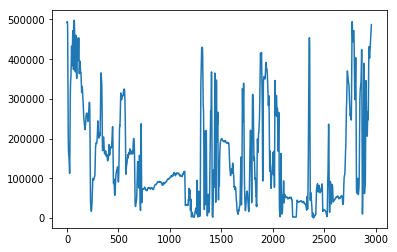

In [283]:
############################################################
#PART 3

# Since I couldn't find any of the descripted keypoints visually, I will choose a random one from ptsR set.

# First step, choose random point from ptsR set (As per the TA's suggestion on MyCourses)
# I have 1932 epipolar lines. ALL of them are horizontal except for 45 lines that are slightly tilted.
# I will avoid choosing any of those 45 tilted lines becuase this will ensure that I will chose a keypoint
# with its correct corresponding epipolar line.



#make a list of the y coordinates of all the horizontal lines (1932-45).. to be used to determine if a keypoint has a line
linesYCoords = []
for line in linesL: 
    x0, y0 = map(int, [0, -line[2]/line[1]])
    x1, y1 = map(int, [col, -(line[2]+line[0]*col)/line[1]])
    if(y0 == y1):
        #only add horiztonal lines
        #anyways, there are only 45 non-horiztonal lines in the set of 1932 lines
        linesYCoords.append(y0)
        
# choosing a random keypoint and enusring that it has a corresponding horizontal epipolar line
notFound = True
while notFound:
    num = np.random.randint(len(ptsR))
    keyPoint = ptsR[num]
    if keyPoint[1] in linesYCoords:
        notFound = False



print("Chosen keypoint on right image", keyPoint)

# 5x5 patch around the random keyPoint
patchR = imgR[keyPoint[1]-2:keyPoint[1]+3, keyPoint[0]-2:keyPoint[0]+3]

#PART 3 DONE
############################################################


############################################################
# PART 4

#A patch of hight 5 around the epipolar line. size = 5ximgWidth.. to be used in template matching
belt = imgL[keyPoint[1]-2:keyPoint[1]+3,:]

#match the the patch around the keypoint to every patch along the epipolar line
res = cv2.matchTemplate(belt, patchR, cv2.TM_SQDIFF)


#find the x coordinates of the match (min_loc) and the value of the SQDIFF
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


#the above method can be implemented manually with the following code:
# for p in range(2, x1-2):
#     patchL = imgL[y0-2:y0+3, p-2:p+3]
#     result = np.absolute(np.array(patchL) - np.array(patchR))
#     ssds.append(np.linalg.norm(result))
# ssds = np.array(ssds)
# min_loc = np.argmin(ssds)
# min_val = ssds.min()
# However, I used the cv2 built in method because it's faster. Otherwise the same patch is found.


# PART 4 DONE
############################################################

############################################################
# PART 5
print("\nsorted SSDs array\n", np.sort(res[0]))
print("\nMin SSD at x position =", min_loc[0])
print("\nMin SSD =", min_val)

print("\nright image patch\n", patchR)
foundPatch = imgL[keyPoint[1]-2:keyPoint[1]+3, min_loc[0]-2:min_loc[0]+3]
print("\nleft image patch\n", foundPatch)

plt.plot(res[0])
plt.show()


#PART 5 DONE
############################################################

### PART 6

### Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

After sorting the SSDs array in part 5, it seems like there's always only one match with the lowest SSD.

Is it the correct match? Yes, for two reasons:
 - The location of the match is always around 200-300 pixels to the right of the keypoint, which is consistent with the difference between the left and right images.
 - Upon inspecting the two patches, they are identical or very similar.

### PART 7

### Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?

The location of the correct match has to be consisten with the difference between the left and right images (the sift). For example in my case, the "left image" is kind of shifted to the right. And upon rough inspection, that shift is around 200-300 pixels (using the numbers on the axis to measure). So the match on the left image has to be at around 200-300 pixels to the right of the location of the chosen keypoint on the right image. 

Of course, we can replace "rough inspection" by a regirous algorithm if the need arises.

### PART 8

### Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?

A threshold for the SSD. In other words, the values of the pixels of the match has to be similar to the chosen keypoint patch to a certain extent.